# pyPanair Tutorial#1 Rectangular Wing  
In this tutorial we will perform an analysis of a rectangular wing with a NACA0012 airfoil.  
A brief overview of the procedure is listed below:  
1. Define the geometry of the wing using `wgs_creator.py`, and create input files `naca0012.wgs` and `naca0012.aux` for `panin`
2. Using the preprocessor `panin`, create an input file `a502.in` for `panair`
3. Run the analysis
4. Visualize the results from the analysis via `agps_converter.py`, `ffmf_converter.py`, and `calc_section_force.py`

## 1. Defining the geometry
### 1.1 LaWGS Format
First off, we will begin by defining the geometry of the rectangular wing.

The input geometry for `panair` (or more precisely, its preprocessor `panin`) is defined in the Langley Wireframe Geometry Standard (LaWGS) format. The format is described in [reference 1](https://ntrs.nasa.gov/search.jsp?R=19850014069).  

In a nutshell, LaWGS files are a bundle of 3 dimensional arrays, which are referred to as "networks". A network is composed of "lines", which in turn is composed of 3-dimensional "points". If a network has `m` lines, and each line of has `n` points, the shape of the corresponding 3d array will be `(m, n, 3)`. Below is an example of a LaWGS file for a delta wing.

```sample1.wgs
deltawing created from wgs_creator
wing
1 3 5 0   0 0 0   0 0 0    1 1 1  0
1.0000000e+01 0.0000000e+00 0.0000000e+00
5.0000000e+00 0.0000000e+00 1.0000000e+00
0.0000000e+00 0.0000000e+00 0.0000000e+00
5.0000000e+00 0.0000000e+00 -1.0000000e+00
1.0000000e+01 0.0000000e+00 0.0000000e+00
7.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 1.0000000e+01 5.0000000e-01
2.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 1.0000000e+01 -5.0000000e-01
7.5000000e+00 1.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
5.0000000e+00 2.0000000e+01 0.0000000e+00
```

The first row displays the title of the LaWGS file.
```
deltawing created from wgs_creator
```

The second row displays the name of the network.
```
wing
```

The third row lists the parameters of the network.
```
1 3 5 0   0 0 0   0 0 0    1 1 1  0
```
The definitions of the first three numbers are as follows:
* "1": the id of the network
* "3": the number of lines in the network
* "5": the number of points in each line

The remaining 11 numbers, `0   0 0 0   0 0 0    1 1 1  0`, define the local and global axes. (Read reference 1 for more information.)  

The fourth and subsequent lines, define the coordinates of each point. For example, the fourth line, `1.0000000e+01 0.0000000e+00 0.0000000e+00`, means that the coordinate of the first point is `x=1., y=0., z=0.`.

The wireframe defined by the above file looks like this ...

<IPython.core.display.Javascript object>


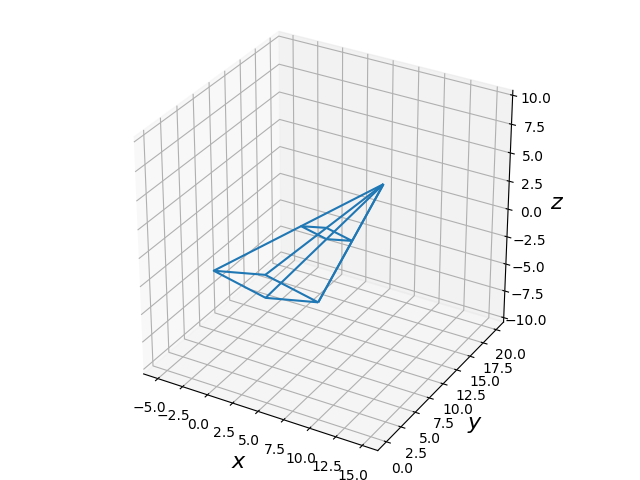

In [2]:
%matplotlib notebook
from pyPanair.preprocess import wgs_creator
delta_wing = wgs_creator.read_wgs("sample1.wgs")
delta_wing._networks[0].plot_wireframe(show_normvec=False, show_corners=False, show_edges=False)

### 1.2 Creating a LaWGS file using pyPanair
Next, we will create a LaWGS file using the `wgs_creator` module of `pyPanair`. In the `wgs_creator` module, LaWGS files are created using objects that derive from the four classes, `LaWGS`, `Network`, `Line`, and `Point`. A brief explanation of these classes are written below.  
* `LaWGS`: A class that represents a LaWGS format geometry as a list of `Networks`. Can be used to read/write LaWGS files.
* `Network`: A class that represents a network as a 3-dimensional array.
* `Line`: A class that represents a line as a 2-dimensional array.
* `Point`: A class that represents the xyz coordinates of a point. A 1-dimensional array is used to define the coordinates.

Now we will begin the actual work of creating a LaWGS file. First, we start of by initializing a `LaWGS` object. The title of the LaWGS object will be `"NACA0012"`.

In [3]:
wgs = wgs_creator.LaWGS("NACA0012")

In the next step, the `Network` of the wing will be defined by interpolating two `Lines`, the `root_airfoil` and `tip_airfoil`. The `root_airfoil`, which is an NACA0012 airfoil, can be constructed using the `naca4digit` method.  

In [4]:
root_airfoil = wgs_creator.naca4digit("0012", num=25, chord=100., span_pos=0.)

The resulting airfoil has a chord length of `100.`, and its spanwise position (e.g. y-axis coordinate) is `0.`.
The upper and lower surfaces are each represented with `25` points.
The x and z coordinates of the airfoil look like below:

<IPython.core.display.Javascript object>


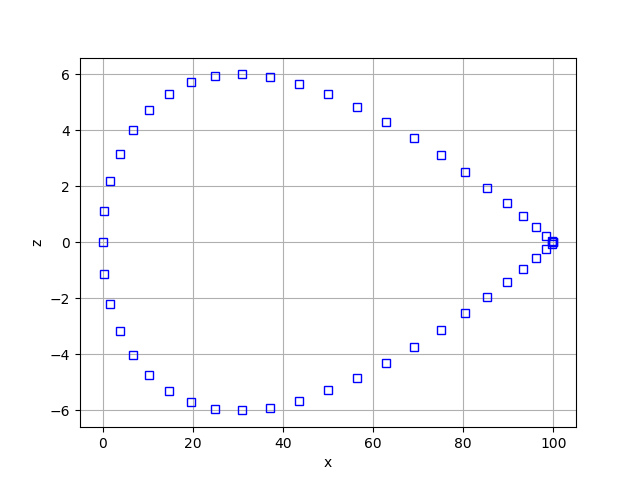

In [6]:
import matplotlib.pyplot as plt
plt.plot(root_airfoil[:,0], root_airfoil[:,2], "s", mfc="None", mec="b")
plt.xlabel("x")
plt.ylabel("z")
plt.grid()

The `tip_airfoil` can be defined in the same manner as the `root_airfoil`.
However, this time, the spanwise position will be `span_pos=300.`.

In [7]:
tip_airfoil = wgs_creator.naca4digit("0012", num=25, chord=100., span_pos=300.)

The `Network` of the wing will be defined by interpolating to the two `Lines`, `root_airfoil` and `tip_airfoil`.
To do so, we simply use the `linspace` method.

In [8]:
wing = root_airfoil.linspace(tip_airfoil, num=20)

The wing `Network` will have `20` lines, which are linear interpolations of the `root_airfoil` and `tip_airfoil`.
`Networks` can be visualized using the `plot_wireframe` method.

<IPython.core.display.Javascript object>


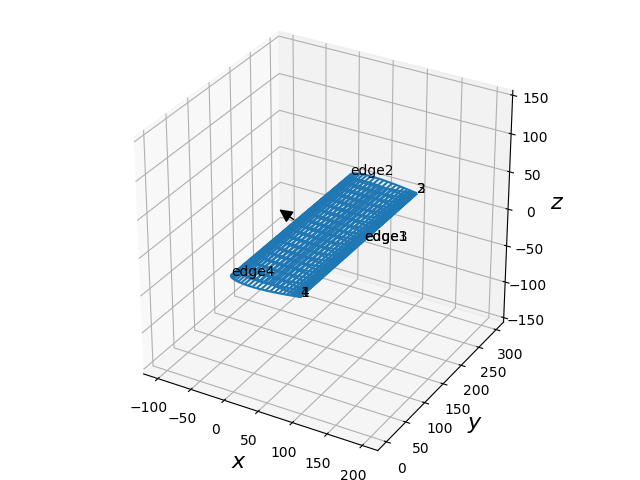

In [9]:
wing.plot_wireframe()

Along with coordinates of each point in the `Network`, the corners (e.g. `1`) and edges (e.g. `edge1`) are displayed.
(Read reference 1 for more information on network corners and edges.)
Also, an arrow indicating the front side of the network is depicted.
(Details of "front side" will be mentioned later.)



After defining the `Network` for the wing, we register it to `wgs`.

In [10]:
wgs.append_network("wing", wing, boun_type=1)

The first variable, `"wing"`, is the name of the network.
The second variable, `wing`, is the `Network` we are registering.
The third variable, `1`, is the boundary type of the network. If the network represents a solid wall, the type is `1`.
(Read [reference 2](https://docs.google.com/file/d/0B2UKsBO-ZMVgS1k5VElNamx1cUk/edit) for more information on the different types of boundary conditions.)

The next process will be to define the geometry of the wingtip.
To do so, we will split the `tip_airfoil` into upper and lower halves, and linearly interpolate them.
All of this can be done by typing

In [11]:
wingtip_upper, wingtip_lower = tip_airfoil.split_half()
wingtip_lower = wingtip_lower.flip()
wingtip = wingtip_upper.linspace(wingtip_lower, num = 5)

The wing tip will look like ...

<IPython.core.display.Javascript object>


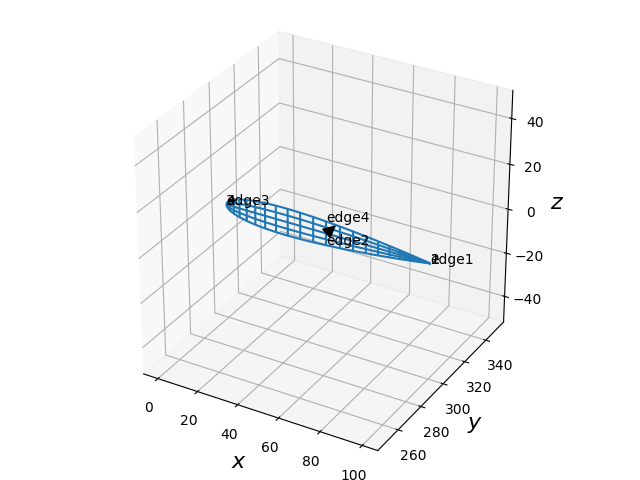

In [12]:
wingtip.plot_wireframe()

The `wingtip` will also be registered to `wgs`.

In [13]:
wgs.append_network("wingtip", wingtip, 1)

Next, we register the `wing`, `wingtip`, and `wingwake` to `wgs`.

In [14]:
wing.make_wake(3, wake_length=50*100.)

TypeError: transpose() takes 1 positional argument but 2 were given